# 房价影响因素的空间异质性研究

**目标**: 本研究探讨广州市中心城区房价（PRI）与其周边环境、设施可达性等因素之间的关系，并重点分析这些影响因素在空间上的异质性。

**流程**:
1.  **数据加载与准备**: 加载由数据处理流水线生成的`data_research.csv`。
2.  **描述性统计与相关性分析**: 了解各变量的基本分布并分析它们之间的线性关系。
3.  **空间自相关分析**:
     - **全局Moran's I**: 检验房价在整体空间上是否存在聚集性。
     - **局部LISA**: 识别房价的高-高（热点）、低-低（冷点）等局部空间聚类模式。
4.  **地理加权回归 (GWR)**: 建立局部回归模型，探究各因素对房价影响的空间非平稳性，并对结果进行可视化。


## 1. 导入必要的库和环境配置

In [21]:
# 导入库
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import pysal.lib as pslib
import seaborn as sns
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from pysal.explore import esda
from scipy import stats

# 导入项目配置
from config.config import (
    RESEARCH_DATA_FILENAME,
    COMMUNITIES_DATA_PROCESSED_DIR,
    CENTER_CITY_SHP_PATH,
    GWR_DEPENDENT_VAR,
    GWR_INDEPENDENT_VARS,
    VIS_STYLE,
    VIS_FONT,
    LISA_RESULTS_DIR,
    GWR_RESULTS_DIR,
    TABLE_DIR
)

# 设置绘图样式
plt.style.use(VIS_STYLE)
plt.rcParams['font.family'] = VIS_FONT
plt.rcParams['axes.unicode_minus'] = False

# 新建目录
os.makedirs(LISA_RESULTS_DIR, exist_ok=True)
os.makedirs(GWR_RESULTS_DIR, exist_ok=True)

## 2. 加载数据与探索

In [18]:
# 加载为研究任务准备的专用数据
research_data_path = f'{COMMUNITIES_DATA_PROCESSED_DIR}/{RESEARCH_DATA_FILENAME}'
df = pd.read_csv(research_data_path)
print("研究数据集信息:")
df.info()

研究数据集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2234 entries, 0 to 2233
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   PRI        2234 non-null   int64  
 1   FAR        2234 non-null   float64
 2   GRE        2234 non-null   float64
 3   PRO        2234 non-null   float64
 4   BUS        2234 non-null   float64
 5   HOS        2234 non-null   float64
 6   MAR        2234 non-null   float64
 7   SUB        2234 non-null   float64
 8   PSC        2234 non-null   float64
 9   MSC        2234 non-null   float64
 10  PAR        2234 non-null   float64
 11  CBD        2234 non-null   float64
 12  SCBD       2234 non-null   float64
 13  RIV        2234 non-null   float64
 14  ARE        2234 non-null   int64  
 15  latitude   2234 non-null   float64
 16  longitude  2234 non-null   float64
dtypes: float64(15), int64(2)
memory usage: 296.8 KB


In [19]:
print("数据描述性统计:")
df.describe()

数据描述性统计:


,PRI,FAR,GRE,PRO,BUS,HOS,MAR,SUB,PSC,MSC,PAR,CBD,SCBD,RIV,ARE,latitude,longitude
count,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000,2234.000000
mean,40450.204566,2.422229,0.264897,1.084467,210.049233,937.326894,446.366160,688.277849,361.390988,480.378604,646.518466,5233.043956,3022.084273,2092.669209,275814.950761,23.120274,113.307816
std,16788.142161,1.437412,0.084107,0.596935,135.929186,689.507569,320.201262,428.036113,235.081438,286.550198,305.178449,2225.738175,1517.138060,1248.994595,152475.305424,0.023467,0.042212
min,11100.000000,0.300000,0.100000,0.200000,5.343864,1.494385,5.010607,6.427364,18.366124,18.444530,32.817434,232.514435,134.657276,1.212449,0.000000,23.052672,113.208664
25%,27800.000000,1.500000,0.200000,0.600000,106.490667,481.023051,185.058998,369.180746,211.981389,278.559636,470.463981,3500.457111,1966.903441,1345.186813,159300.000000,23.098951,113.273426
50%,37000.000000,2.100000,0.300000,0.900000,176.507809,857.983786,432.607268,674.453877,282.588842,428.682369,600.304011,4998.925107,2978.252475,2104.807143,272100.000000,23.128472,113.312602
75%,49539.000000,2.800000,0.300000,1.500000,283.420829,1145.558158,588.955271,941.159316,425.833151,601.973365,833.711955,6450.982729,3742.196409,2488.220545,352900.000000,23.135260,113.335456
max,154861.000000,11.330000,0.500000,2.800000,844.397067,7353.738349,3118.812896,2810.213535,1643.507356,2355.956297,1737.995511,13872.507933,11175.778908,11516.574452,848800.000000,23.215595,113.426950


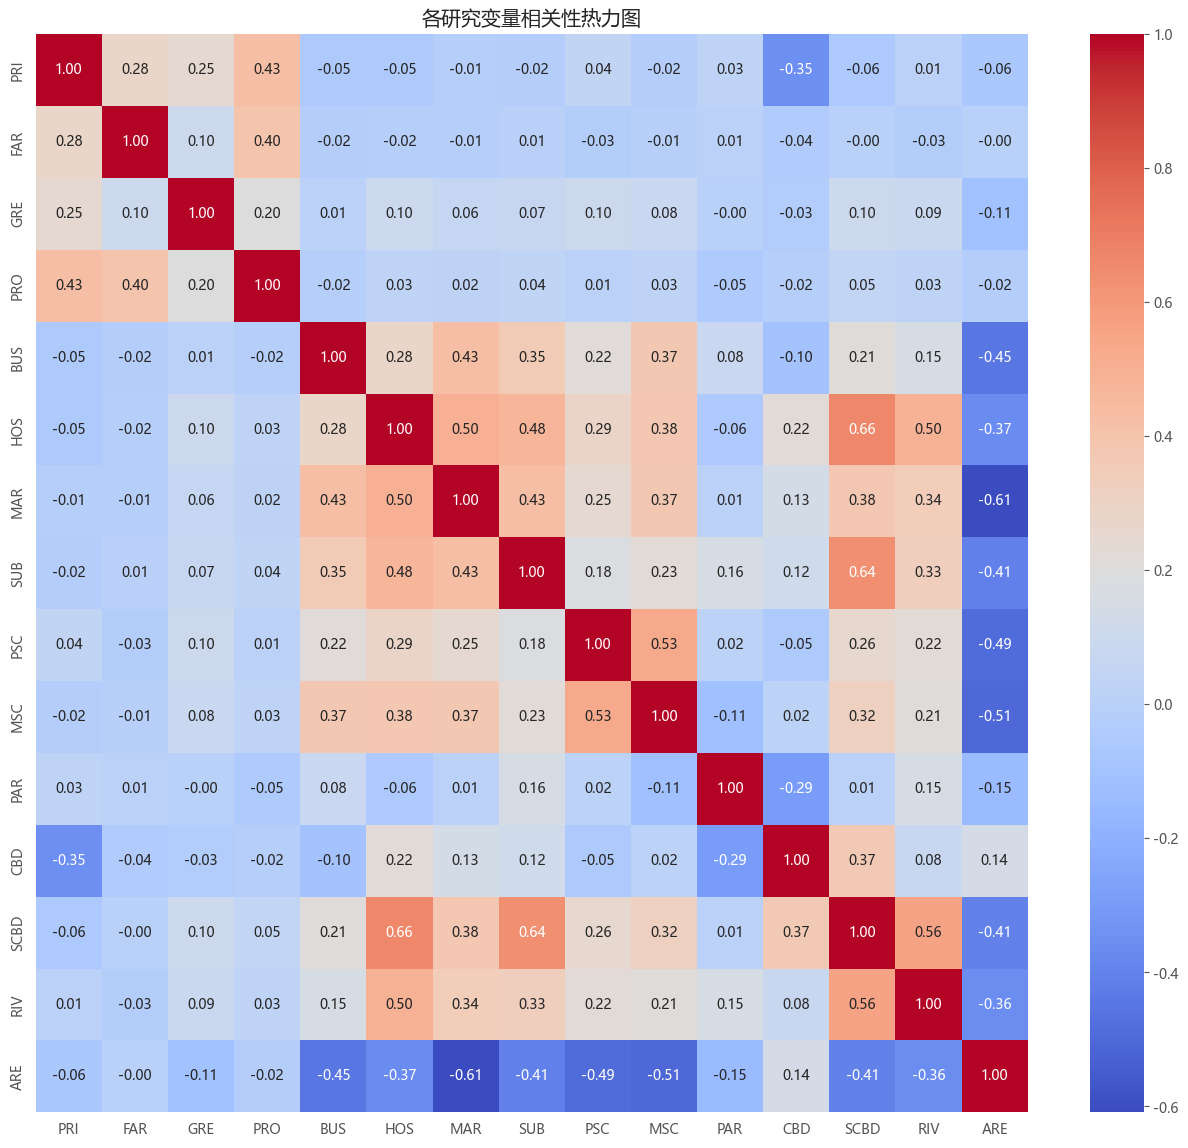

In [22]:
# 绘制相关性热力图
plt.figure(figsize=(16, 14))
corr = df.drop(['latitude', 'longitude'], axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('各研究变量相关性热力图')
plt.show()

## 3. 空间自相关分析

In [5]:
# 创建GeoDataFrame以进行空间分析
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs='EPSG:4326'
)
df['geometry'] = gdf['geometry'].apply(lambda p: (p.x, p.y))
# 使用距离阈值法构建空间权重矩阵
# 这里的0.05大约对应5.5km
w = pslib.weights.DistanceBand.from_dataframe(df, threshold=0.05, ids=gdf.index)

### 3.1 全局 Moran's I

In [6]:
moran = esda.Moran(gdf[GWR_DEPENDENT_VAR], w)

print(f"全局 Moran's I 指数: {moran.I:.4f}")
print(f"Z-score: {moran.z_norm:.4f}")
print(f"P-value: {moran.p_norm:.4f}")

if moran.p_norm < 0.01: #
    print("结论: P值显著小于0.01，表明房价在空间上存在显著的正向自相关（聚集）现象。")
else:
    print("结论: P值不显著，房价在空间上呈随机分布。")

全局 Moran's I 指数: 0.0787
Z-score: 88.5908
P-value: 0.0000
结论: P值显著小于0.01，表明房价在空间上存在显著的正向自相关（聚集）现象。


### 3.2 局部 Moran's I (LISA)

In [7]:
# 计算LISA
lisa = esda.moran.Moran_Local(gdf[GWR_DEPENDENT_VAR], w)
# 将LISA结果添加到GeoDataFrame中
gdf['lisa_q'] = lisa.q
gdf['lisa_p'] = lisa.p_sim
# 筛选出显著的聚类
significant_clusters = gdf[gdf['lisa_p'] < 0.05]

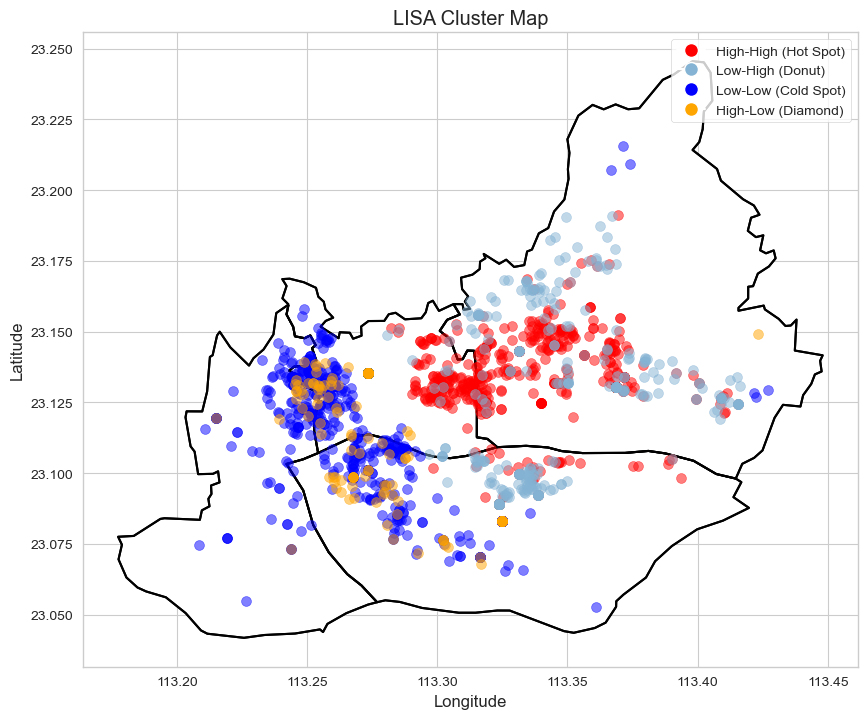

In [8]:
# 将LISA集聚类型添加到数据中
gdf['lisa_type'] = lisa.q
# 定义颜色映射
cmap = plt.get_cmap('Set1')
# 定义集聚类型的解释
lisa_labels = {
    1: 'High-High (Hot Spot)',
    2: 'Low-High (Donut)',
    3: 'Low-Low (Cold Spot)',
    4: 'High-Low (Diamond)'
}
# 定义颜色
colors = {1: 'red', 2: '#84B3D4', 3: 'blue', 4: '#FFA500'}
# 绘制LISA集聚图
fig, ax = plt.subplots(figsize=(10, 10))

# 绘制广州市中心城区边界作为底图
center_city_boundary = gpd.read_file(CENTER_CITY_SHP_PATH)
center_city_boundary.plot(ax=ax, color='white', edgecolor='black', linewidth=1.5)

# 先绘制广州市中心城区边界
center_city_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)

for ctype, data in significant_clusters.groupby('lisa_q'):
    data.plot(ax=ax, color=colors[ctype], label=lisa_labels[ctype], markersize=50, alpha=0.5)

# 添加标题和坐标轴标签
ax.set_title('LISA Cluster Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# 创建图例
handles, labels = [], []
for ctype, label in lisa_labels.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[ctype], markersize=10))
    labels.append(label)
plt.legend(handles=handles, labels=labels)

# 保存图形
plt.savefig(f'{LISA_RESULTS_DIR}/lisa_cluster.png')
plt.show()

In [9]:
plt.close()

## 4. GWR 回归

In [10]:
# 准备GWR模型所需数据
gwr_data = gdf.drop_duplicates(subset=['latitude', 'longitude']).copy()
coords = list(zip(gwr_data['longitude'], gwr_data['latitude']))
y = gwr_data[GWR_DEPENDENT_VAR].values.reshape(-1, 1)
X = gwr_data[GWR_INDEPENDENT_VARS].values

print(f"GWR模型样本量: {len(y)}")
print(f"自变量数量: {X.shape[1]}")

GWR模型样本量: 1188
自变量数量: 14


In [11]:
# 使用高斯核函数和AICc准则搜索最优带宽
selector = Sel_BW(coords, y, X, kernel='gaussian')
bw = selector.search()
print(f"搜索到的最优带宽 (邻居数): {bw}")

搜索到的最优带宽 (邻居数): 71.0


In [12]:
# 拟合GWR模型
gwr_model = GWR(coords, y, X, bw=bw, kernel='gaussian').fit()

# 查看模型摘要
gwr_model.summary()

Model type                                                         Gaussian
Number of observations:                                                1188
Number of covariates:                                                    15

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       183845345979.910
Log-likelihood:                                                  -12886.956
AIC:                                                              25803.911
AICc:                                                             25806.376
BIC:                                                           183845337675.038
R2:                                                                   0.450
Adj. R2:                                                              0.444

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------

In [13]:
# 导出模型摘要为CSV文件
summary_data = {
    'Variable': ['Intercept'] + GWR_INDEPENDENT_VARS,
    'Coefficient': gwr_model.params[0],
    'Std.Error': gwr_model.bse[0],
    't-value': gwr_model.tvalues[0],
    'p-value': 2 * (1 - stats.t.cdf(abs(gwr_model.tvalues[0]), df=gwr_model.df_model))
}

# 添加模型整体指标
summary_df = pd.DataFrame(summary_data)
model_stats = pd.DataFrame({
    'Variable': ['R-squared', 'Adjusted R-squared', 'AICc', 'Bandwidth'],
    'Coefficient': [gwr_model.R2, gwr_model.adj_R2, gwr_model.aicc, bw],
    'Std.Error': ['']*4,
    't-value': ['']*4,
    'p-value': ['']*4
})

summary_df = pd.concat([summary_df, model_stats], ignore_index=True)
summary_df.to_csv(f'{TABLE_DIR}/gwr_summary.csv', index=False, float_format='%.4f')

In [14]:
# 提取回归系数和t值
coef_df = pd.DataFrame(gwr_model.params, columns=['Intercept'] + GWR_INDEPENDENT_VARS)
t_values = pd.DataFrame(gwr_model.tvalues, columns=['Intercept'] + GWR_INDEPENDENT_VARS)

# 计算p值
p_values = pd.DataFrame(2 * (1 - stats.t.cdf(abs(t_values), df=gwr_model.df_model)),
                        columns=['Intercept'] + GWR_INDEPENDENT_VARS)
# 设定显著性水平
alpha = 0.05
# 输出各因素的p值和显著性水平
print("各因素的p值和显著性水平：")
significant_factors = []
for factor in p_values.columns:
    p_value = p_values[factor].values[0]
    significant = "显著" if p_value < alpha else "不显著"
    print(f"{factor}: p值 = {p_value:.4f}, {significant}")
    if p_value < alpha:
        significant_factors.append(factor)
    else:
        pass

各因素的p值和显著性水平：
Intercept: p值 = 0.0000, 显著
FAR: p值 = 0.0000, 显著
PRO: p值 = 0.0000, 显著
GRE: p值 = 0.0001, 显著
BUS: p值 = 0.6267, 不显著
SUB: p值 = 0.0000, 显著
HOS: p值 = 0.0511, 不显著
PSC: p值 = 0.3448, 不显著
MSC: p值 = 0.0313, 显著
PAR: p值 = 0.4468, 不显著
CBD: p值 = 0.0000, 显著
SCBD: p值 = 0.0039, 显著
MAR: p值 = 0.7257, 不显著
ARE: p值 = 0.0202, 显著
RIV: p值 = 0.0037, 显著


In [15]:
significant_coef_df = coef_df[significant_factors].copy()
significant_coef_df = significant_coef_df.drop('Intercept', axis=1)
significant_coef_gdf = gpd.GeoDataFrame(significant_coef_df, geometry= gpd.points_from_xy(gwr_data.longitude, gwr_data.latitude))

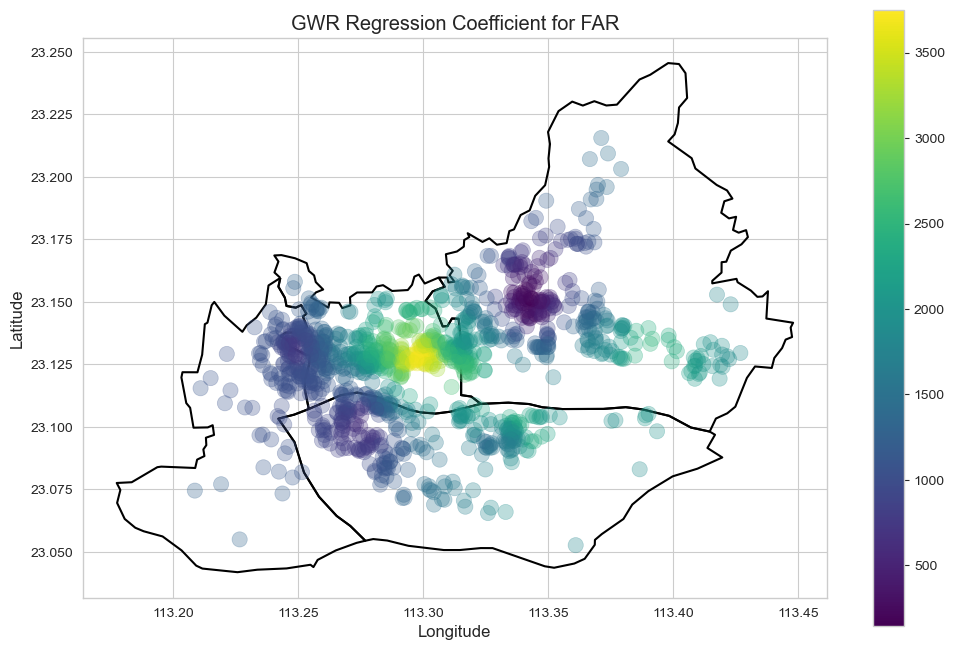

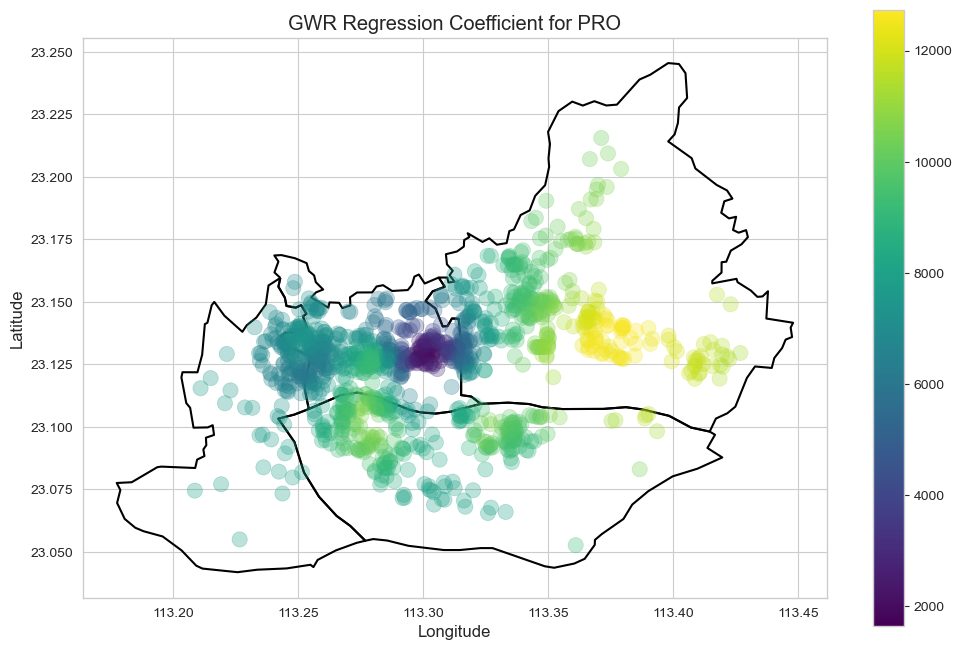

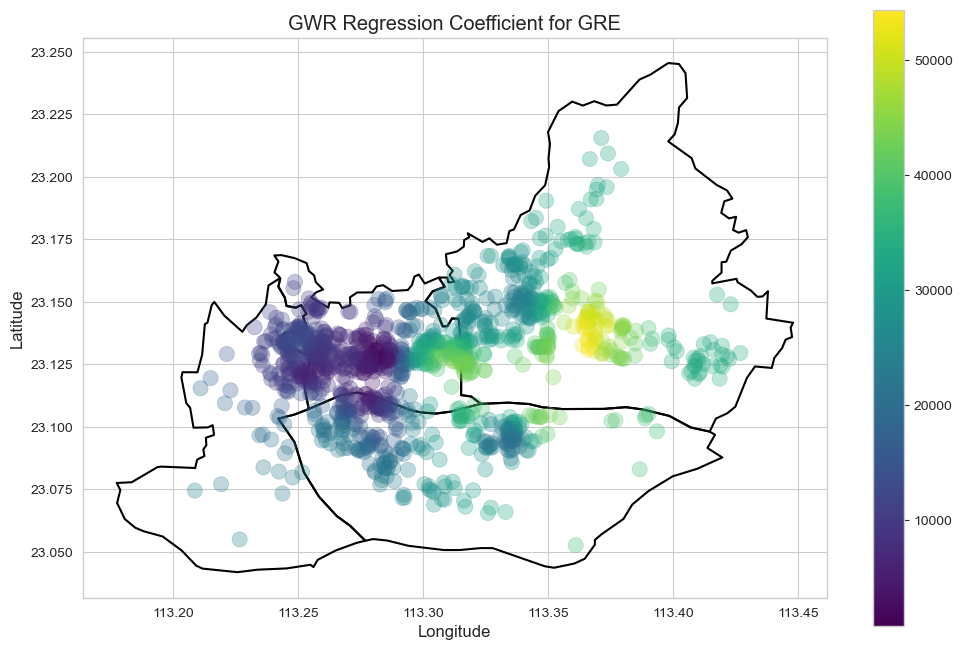

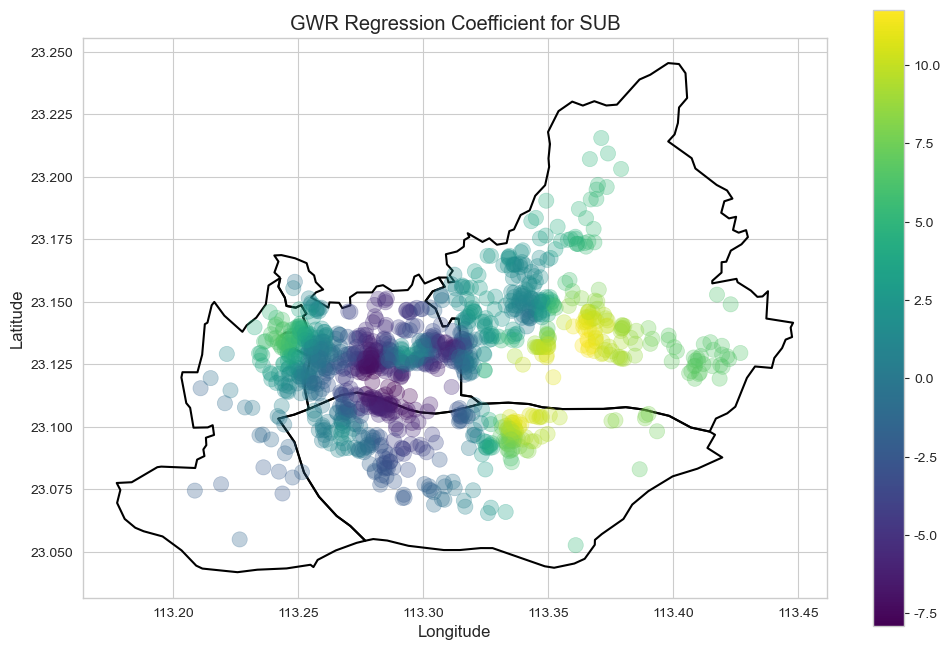

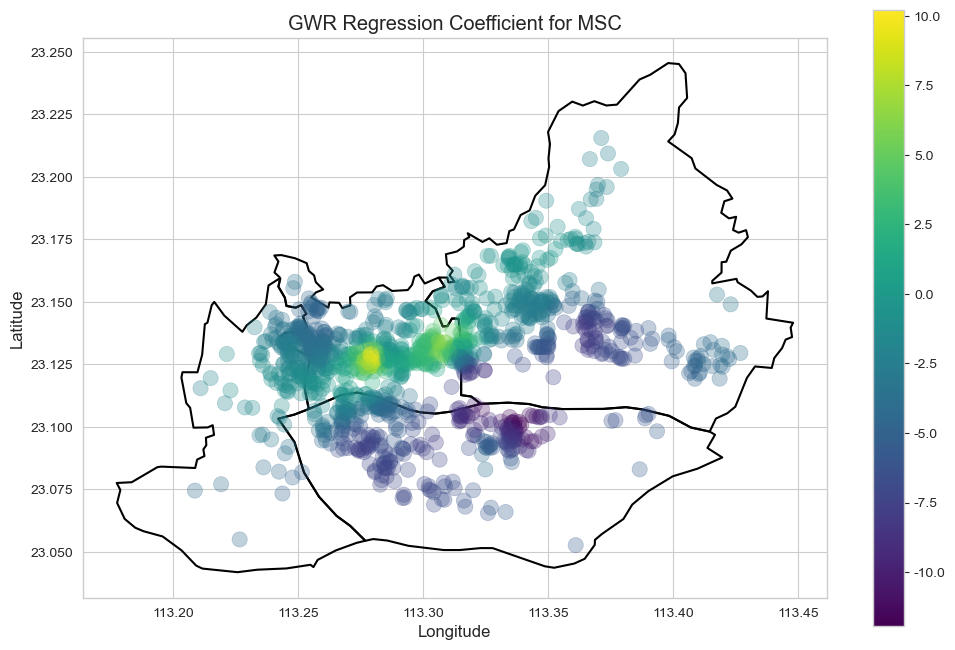

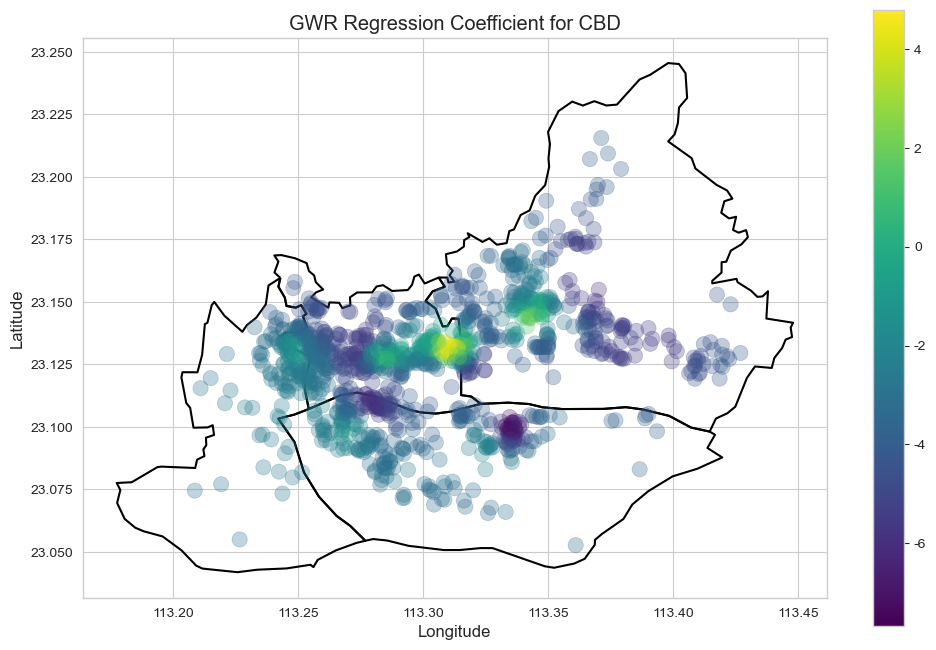

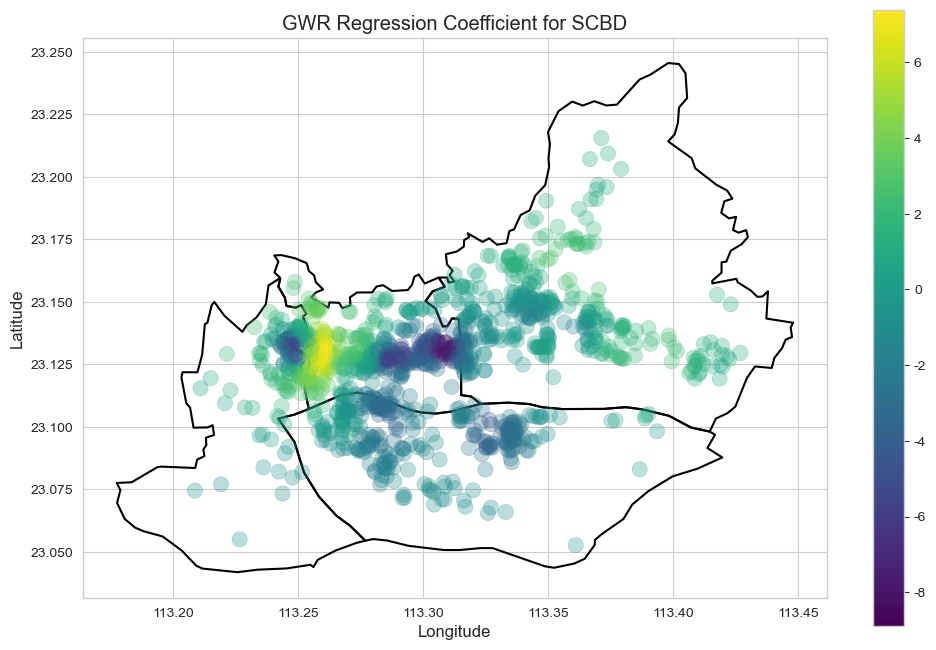

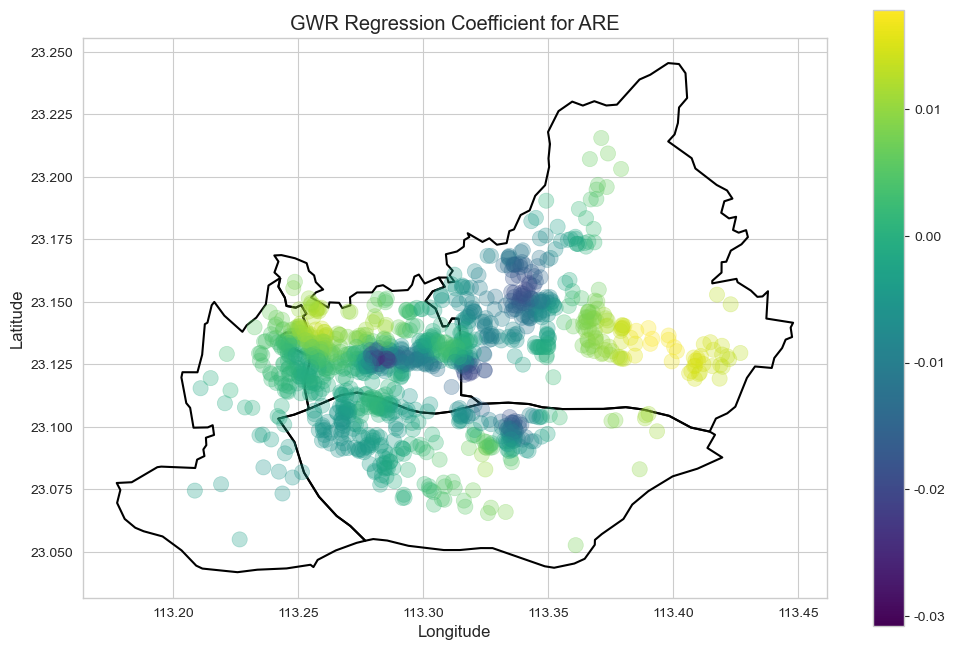

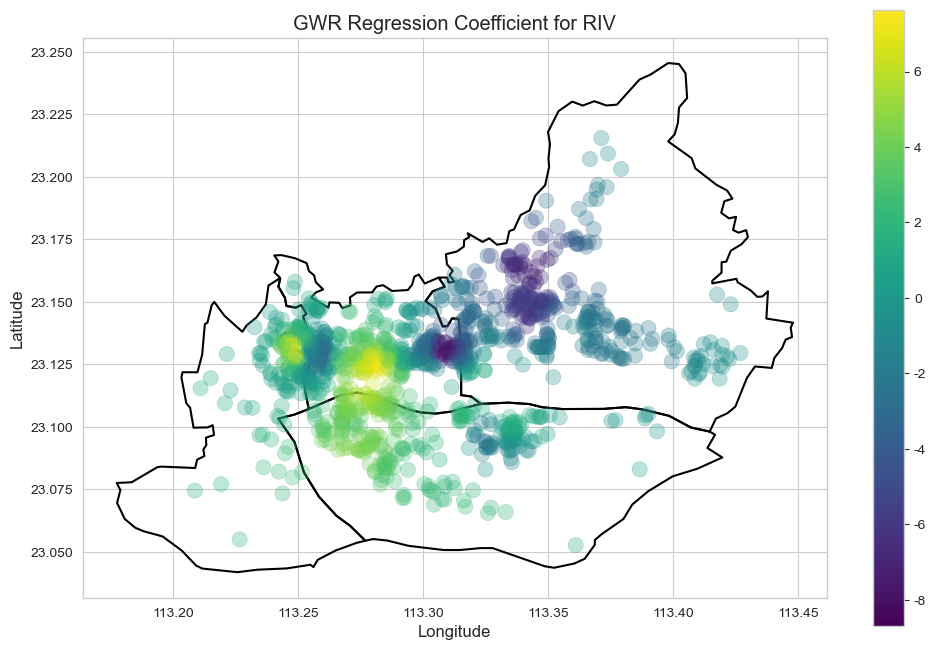

In [16]:
# 可视化显著因素的回归系数
for factor in significant_factors[1:]:
    fig, ax = plt.subplots(figsize=(12, 8))
    center_city_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)
    significant_coef_gdf.plot(column=factor, ax=ax, cmap='viridis', legend=True, markersize = 120, alpha=0.3)
    ax.set_title(f'GWR Regression Coefficient for {factor}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.savefig(f'{GWR_RESULTS_DIR}/gwr_coef_{factor}.png', bbox_inches='tight')
    plt.show()